#   Лабораторная работа 4. Анализ и визуализация данных. Вариант 3


In [10]:
import pandas as pd
import csv
import typing
from typing import List, Tuple
import random
import matplotlib.pyplot as plt
import cv2

def read_file(path: str) -> List[Tuple[str, str]]:
    '''Читает файл path и возвращает список кортежей с именами файлов и их классами'''
    files: List[Tuple[str, str]] = []
    with open(path, "r") as csvfile:
        reader = csv.DictReader(csvfile, delimiter=",")
        for row in reader:
            files.append((row["full_path"], row["class"]))
    return files

list_information: List[Tuple[str, str]] = read_file("annotation.csv")


1. Создание Dataframe с двумя колонками (название класса и абсолютный путь к файлу)

In [8]:
"""
 Создание датафрейма

    Parameters
    ----------
    list_information
     Список файлов из аннотации
    Returns
    -------
    pd.DataFrame
     Датафрейм в 2 колонки
 """
def create_df(list_information)->pd.DataFrame:
    df = pd.DataFrame(columns=["Class", "Abs_Path"])
    for file_info in list_information:
        df.loc[len(df)] = [file_info[1], file_info[0]]
    return df

create_df(list_information)

,Class,Abs_Path
0,cats,/Users/polina/Documents/Programm-lab/dataset/c...
1,cats,/Users/polina/Documents/Programm-lab/dataset/c...
2,cats,/Users/polina/Documents/Programm-lab/dataset/c...
3,cats,/Users/polina/Documents/Programm-lab/dataset/c...
4,cats,/Users/polina/Documents/Programm-lab/dataset/c...
...,...,...
1995,dogs,/Users/polina/Documents/Programm-lab/dataset/d...
1996,dogs,/Users/polina/Documents/Programm-lab/dataset/d...
1997,dogs,/Users/polina/Documents/Programm-lab/dataset/d...
1998,dogs,/Users/polina/Documents/Programm-lab/dataset/d...


2-4. Именование колонок, числовая метка, информация о высоте, ширине и глубине  изображения

In [11]:
"""
 Добавление нескольких колонок по метке

    Parameters
    ----------
    list_information
     Список файлов из аннотации
    Returns
    -------
    pd.DataFrame
     Датафрейм 
 """
def create_df(list_information)->pd.DataFrame:
    df = pd.DataFrame(columns=["Class", "Abs_Path", "Id", "Weight", "Height", "Depth"])
    for file_info in list_information:
        id = (0 if "cats" == file_info[1] else 1)
        im = cv2.imread(file_info[0])
        H,W,D = im.shape
        df.loc[len(df)] = [file_info[1], file_info[0], id, W,H,D]
    return df

df = create_df(list_information)
df

,Class,Abs_Path,Id,Weight,Height,Depth
0,cats,/Users/polina/Documents/Programm-lab/dataset/c...,0,448,320,3
1,cats,/Users/polina/Documents/Programm-lab/dataset/c...,0,480,300,3
2,cats,/Users/polina/Documents/Programm-lab/dataset/c...,0,480,320,3
3,cats,/Users/polina/Documents/Programm-lab/dataset/c...,0,448,320,3
4,cats,/Users/polina/Documents/Programm-lab/dataset/c...,0,480,270,3
...,...,...,...,...,...,...
1995,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,300,3
1996,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,248,320,3
1997,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,319,3
1998,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,289,3


5. Вычисление статистической информации


In [12]:
"""
 Вычисление информации о размере изображений

    Parameters
    ----------
    df
     Датафрейм
    Returns
    -------
    pd.DataFrame
     Датафрейм со значениями
 """
def get_static_info(df)->pd.DataFrame:
    
    return {"Height": df["Height"].mean(), "Weight": df["Weight"].mean(),
            "Depht":  df["Depth"].mean(), "Id": df["Id"].mean()}

get_static_info(df)

{'Height': 305.3425, 'Weight': 444.026, 'Depht': 3.0, 'Id': 0.5}

6. Отфильтрованный по метке класса DataFrame

In [14]:
"""
 Фильтрация датафрейма

    Parameters
    ----------
    df
     Датафрейм
    id
     Идентификатор класса

    Returns
    -------
    pd.DataFrame
     Датафрейм
 """
def filter_class_id(df, id) -> pd.DataFrame:
    return df.loc[ df["Id"] == id ]

filter_class_id(df, 1)

,Class,Abs_Path,Id,Weight,Height,Depth
1000,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,320,3
1001,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,320,3
1002,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,400,320,3
1003,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,300,3
1004,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,320,3
...,...,...,...,...,...,...
1995,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,300,3
1996,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,248,320,3
1997,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,319,3
1998,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,289,3


7. Отфильтрованный по заданным параметрам DataFrame

In [16]:
"""
 Фильтрация датафрейма по заданным параметрам

    Parameters
    ----------
    df
     Датафрейм
    weight
     Ширина
    height
     Высота
    id
     Идентификатор класса

    Returns
    -------
    pd.DataFrame
     Датафрейм
 """
def filter_given_parameters(df, weight, height, id)->pd.DataFrame:
     return df.loc[ (df["Id"] == id) & (df["Weight"] <= weight) & (df["Height"] <= height) ]

filter_given_parameters(df, 320, 320, 1)

,Class,Abs_Path,Id,Weight,Height,Depth
1027,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,288,320,3
1044,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,320,320,3
1052,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,320,320,3
1053,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,320,320,3
1068,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,240,320,3
...,...,...,...,...,...,...
1973,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,320,320,3
1979,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,320,320,3
1982,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,240,320,3
1993,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,229,320,3


8. Группировка DataFrame

In [21]:
"""
 Вычисление информации по количеству пикселей

    Parameters
    ----------
    df
     Датафрейм
    Returns
    -------
    pd.DataFrame
     Датафрейм
 """
def df_pixel_counting(df)->pd.DataFrame:
    return df.assign(Pixel_Quantity = df["Height"] * df["Weight"])

df = df_pixel_counting(df)
df

,Class,Abs_Path,Id,Weight,Height,Depth,PixelSize,Pixel_Quantity
0,cats,/Users/polina/Documents/Programm-lab/dataset/c...,0,448,320,3,143360,143360
1,cats,/Users/polina/Documents/Programm-lab/dataset/c...,0,480,300,3,144000,144000
2,cats,/Users/polina/Documents/Programm-lab/dataset/c...,0,480,320,3,153600,153600
3,cats,/Users/polina/Documents/Programm-lab/dataset/c...,0,448,320,3,143360,143360
4,cats,/Users/polina/Documents/Programm-lab/dataset/c...,0,480,270,3,129600,129600
...,...,...,...,...,...,...,...,...
1995,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,300,3,144000,144000
1996,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,248,320,3,79360,79360
1997,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,319,3,153120,153120
1998,dogs,/Users/polina/Documents/Programm-lab/dataset/d...,1,480,289,3,138720,138720


In [22]:
def df_group_class_id(df)->pd.DataFrame:
    return df.groupby(["Id"])

group_df = df_group_class_id(df)

Минимум


In [23]:
group_df["Pixel_Quantity"].min()

Id
0    57600
1    57600
Name: Pixel_Quantity, dtype: int64

Максимум

In [24]:
group_df["Pixel_Quantity"].max()

Id
0    153600
1    153600
Name: Pixel_Quantity, dtype: int64

Среднее значение

In [26]:
group_df["Pixel_Quantity"].mean()

Id
0    134305.92
1    136490.72
Name: Pixel_Quantity, dtype: float64

9. Построение гистограммы

In [48]:
"""
 Построение гистограммы

    Parameters
    ----------
    df
     Датафрейм
    id
     Идентификатор класса
    Returns
    -------
    typing.Sequence[cv2.typing.MatLike]
     Изображение гистограммы
  
 """
def get_gist_channels(df, id) -> typing.Sequence[cv2.typing.MatLike]:
    filter = filter_class_id(df, id)
    path = filter["Abs_Path"][random.randint(0, len(filter)-1)]
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.split(img)

p, g, v = get_gist_channels(df, 0)

10. Отрисовка гистограммы

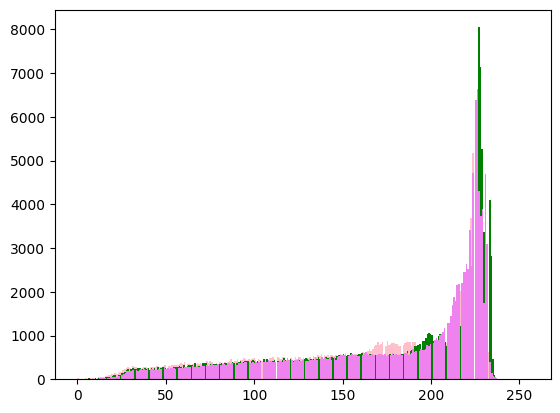

In [46]:
plt.hist(p.ravel(), bins=280, color='pink')
plt.hist(g.ravel(), bins=280, color='green')
plt.hist(v.ravel(), bins=280, color='violet')
plt.xlabel("Ось X")
plt.ylabel("Ось Y")
plt.title("Гистограмма")
plt.show()